# Titiler-CMR Performance Benchmarking and Compatibility

This notebook helps you **validate compatibility** and **measure performance** of [TiTiler-CMR] tile rendering endpoints at different zoom levels for a given **Earthdata CMR concept ID**.

> **What is TiTiler-CMR?**  
> [TiTiler](https://github.com/developmentseed/titiler) is a lightweight dynamic tiling server for raster/COG data. **TiTiler-CMR** is a variant/deployment that integrates with NASA's **Common Metadata Repository (CMR)** so you can render tiles **directly from CMR-managed datasets** (e.g., HDF5/NetCDF4/GRIB hosted on Earthdata Cloud). It can resolve a **CMR concept ID** to a renderable item, and expose tile and statistics endpoints without you needing to manually construct source URLs.



In [1]:
import asyncio
import pandas as pd
from datetime import datetime

import morecantile

# Local imports
from datacube_benchmark.titiler_cmr_utils import (
    DatasetParams,
    check_titiler_cmr_compatibility,
    benchmark_titiler_cmr,
)
pd.set_option("display.max_rows", 100)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
pd.set_option("display.max_colwidth", 120)

ModuleNotFoundError: No module named 'morecantile'

## Setup

- Choose a Titiler-CMR endpoint
- Pick a collection
- Define a temporal interval and (optionally) band list

In [2]:
endpoint = "https://staging.openveda.cloud/api/titiler-cmr"
concept_id = "C2021957295-LPCLOUD"  # Example: HLS Landsat 30m

# Tile Matrix Set
projection = "WebMercatorQuad"
tms = morecantile.tms.get(projection)

# Dataset parameters
ds = DatasetParams(
    concept_id=concept_id,
    datetime_start=datetime(2024, 5, 1),
    datetime_end=datetime(2024, 5, 2),
    assets=["B04", "B03", "B02"],        # RGB bands
)


lng, lat = -91.0321, 46.7653

min_zoom, max_zoom = 3, 18      
tile_format = "png"
timeout_s = 30.0

## Compatibility Testing


Perform a lightweight compatibility test for a dataset (concept ID). It attempts a single **tile** at a representative (lon, lat, zoom) across several formats and resampling modes.

In [3]:
async def run_compat():
    report = await check_titiler_cmr_compatibility(
        endpoint=endpoint,
        ds=ds,
        lng=lng,
        lat=lat,
        zoom=8,
        tile_matrix_set_id="WebMercatorQuad",
        formats=["png", "jpeg", "webp", "tiff", "npy", "jp2", "pngraw", "jpg"],
        resampling_methods=("nearest", "bilinear"),
    )
    return report

compat = await run_compat()
print("\n== Compatibility Report ==")
print(f"concept_id : {compat.concept_id}")
print(f"compatible : {compat.ok}")
print(f"formats    : {compat.tested_formats}")
print(f"resampling : {compat.tested_resampling}")

Trying info path: info
Trying info path: metadata
Trying info path: collection
Trying info path: capabilities

== Compatibility Report ==
concept_id : C2021957295-LPCLOUD
compatible : True
formats    : {'png': True, 'jpeg': True, 'webp': True, 'tiff': True, 'npy': True, 'jp2': True, 'pngraw': True, 'jpg': True}
resampling : {'nearest': True, 'bilinear': True}


## Tiling Benchmark

Measures response latency across a small window of tiles at each zoom.  
This approximates the load of a typical viewport render in a slippy map.


Create (or reuse) a blosc compressed array with 25 KB chunks

In [4]:
async def run_tile_benchmark():
    df = await benchmark_titiler_cmr(
        endpoint=endpoint,
        ds=ds,
        tms=tms,
        min_zoom=min_zoom,
        max_zoom=max_zoom,
        lng=lng,
        lat=lat,
        format=tile_format,
        timeout_s=timeout_s,
    )
    return df

df_tiles =  await run_tile_benchmark()
df_tiles.head(10)

Benchmarking Zoom level: 3...
Benchmarking Zoom level: 4...
Benchmarking Zoom level: 5...
Benchmarking Zoom level: 6...
Benchmarking Zoom level: 7...
Benchmarking Zoom level: 8...
Benchmarking Zoom level: 9...
Benchmarking Zoom level: 10...
Benchmarking Zoom level: 11...
Benchmarking Zoom level: 12...
Benchmarking Zoom level: 13...
Benchmarking Zoom level: 14...
Benchmarking Zoom level: 15...
Benchmarking Zoom level: 16...
Benchmarking Zoom level: 17...
Benchmarking Zoom level: 18...


,zoom,x,y,status_code,response_time_sec,response_size_bytes,is_error,has_data
0,3,0,0,200,0.173361,704,False,True
1,3,0,0,200,0.167996,704,False,True
2,3,1,0,200,0.161934,704,False,True
3,3,2,0,200,0.159598,704,False,True
4,3,3,0,200,0.131204,704,False,True
5,3,0,1,200,0.155661,704,False,True
6,3,0,1,200,0.170351,704,False,True
7,3,1,1,200,0.163028,704,False,True
8,3,2,1,200,0.167435,704,False,True
9,3,3,1,200,0.181842,704,False,True


**Columns**
- `zoom, x, y` — XYZ tile indices
- `status_code` — HTTP code (200 = success, 204 = no-data, 4xx/5xx = errors)
- `response_time_sec` — wall time in seconds
- `response_size_bytes` — payload size
- `is_error, has_data` — convenience flags

Below are some quick summaries.


In [9]:
def summarize_tiles(df: pd.DataFrame) -> pd.DataFrame:
    if df.empty:
        return df

    g = df.groupby("zoom")
    out = pd.DataFrame({
        "zoom_level": g.size().index,
        "total_requests": g.size().values,
        "success_rate_pct": 100 * g["status_code"].apply(lambda s: (s == 200).mean()),
        "no_data_rate_pct": 100 * g["status_code"].apply(lambda s: (s == 204).mean()),
        "error_rate_pct": 100 * g["is_error"].mean(),
        "latency_median_s": g["response_time_sec"].quantile(0.5),
        "latency_p95_s": g["response_time_sec"].quantile(0.95),
        "avg_response_size_bytes": g["response_size_bytes"].mean(),
    }).reset_index(drop=True)

    # Rounding for readability
    for c in ("success_rate_pct", "no_data_rate_pct", "error_rate_pct"):
        out[c] = out[c].round(2)
    out["latency_median_s"] = out["latency_median_s"].round(4)
    out["latency_p95_s"] = out["latency_p95_s"].round(4)
    out["avg_response_size_bytes"] = out["avg_response_size_bytes"].round(1)

    return out.sort_values("zoom_level")


tile_summary = summarize_tiles(df_tiles)
tile_summary


,zoom_level,total_requests,success_rate_pct,no_data_rate_pct,error_rate_pct,latency_median_s,latency_p95_s,avg_response_size_bytes
0,3,25,100.0,0.0,0.0,0.1404,0.1845,704.0
1,4,25,100.0,0.0,0.0,0.1282,0.1642,704.0
2,5,25,100.0,0.0,0.0,0.1324,0.1915,704.0
3,6,25,100.0,0.0,0.0,0.1205,0.1619,704.0
4,7,25,100.0,0.0,0.0,0.1297,0.1788,704.0
5,8,25,100.0,0.0,0.0,0.1225,0.1536,704.0
6,9,25,100.0,0.0,0.0,0.1231,0.1608,704.0
7,10,25,100.0,0.0,0.0,0.1237,0.1672,704.0
8,11,25,100.0,0.0,0.0,0.1276,0.1705,704.0
9,12,25,100.0,0.0,0.0,0.1188,0.1637,704.0


Now, let's create a simple latency plot: 

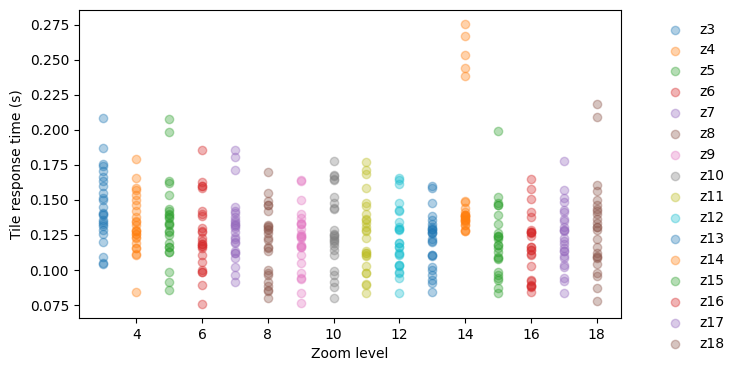

In [10]:
import matplotlib.pyplot as plt

# Simple latency plot
if not df_tiles.empty:
    plt.figure(figsize=(7,4))
    ax = plt.gca()
    for z, sub in df_tiles.groupby("zoom"):
        ax.scatter([z]*len(sub), sub["response_time_sec"], alpha=0.35, label=f"z{z}")
    ax.set_xlabel("Zoom level")
    ax.set_ylabel("Tile response time (s)")
    handles, labels = ax.get_legend_handles_labels()
    bylabel = dict(zip(labels, handles))
    ax.legend(
        bylabel.values(),
        bylabel.keys(),
        frameon=False,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )
    plt.show()


Now, let's try to create similar plots for longer datetime range: 

In [11]:
ds = DatasetParams(
    concept_id=concept_id,
    datetime_start=datetime(2024, 1, 1),
    datetime_end=datetime(2024, 6, 1),
    assets=["B04", "B03", "B02"],
)

async def run_tile_benchmark():
    df = await benchmark_titiler_cmr(
        endpoint=endpoint,
        ds=ds,
        tms=tms,
        min_zoom=min_zoom,
        max_zoom=max_zoom,
        lng=lng,
        lat=lat,
        format=tile_format,
        timeout_s=timeout_s,
    )
    return df

df_tiles =  await run_tile_benchmark()
tile_summary = summarize_tiles(df_tiles)
tile_summary

Benchmarking Zoom level: 3...
Benchmarking Zoom level: 4...
Benchmarking Zoom level: 5...
Benchmarking Zoom level: 6...
Benchmarking Zoom level: 7...
Benchmarking Zoom level: 8...
Benchmarking Zoom level: 9...
Benchmarking Zoom level: 10...
Benchmarking Zoom level: 11...
Benchmarking Zoom level: 12...
Benchmarking Zoom level: 13...
Benchmarking Zoom level: 14...
Benchmarking Zoom level: 15...
Benchmarking Zoom level: 16...
Benchmarking Zoom level: 17...
Benchmarking Zoom level: 18...


,zoom_level,total_requests,success_rate_pct,no_data_rate_pct,error_rate_pct,latency_median_s,latency_p95_s,avg_response_size_bytes
0,3,25,100.0,0.0,0.0,0.2212,0.2604,704.0
1,4,25,100.0,0.0,0.0,0.1476,0.2160,704.0
2,5,25,100.0,0.0,0.0,0.1304,0.1908,704.0
3,6,25,100.0,0.0,0.0,0.1552,0.2048,704.0
4,7,25,100.0,0.0,0.0,0.1286,0.1613,704.0
5,8,25,100.0,0.0,0.0,0.1215,0.1826,704.0
6,9,25,100.0,0.0,0.0,0.1205,0.1515,704.0
7,10,25,100.0,0.0,0.0,0.1171,0.1485,704.0
8,11,25,100.0,0.0,0.0,0.1273,0.2045,704.0
9,12,25,100.0,0.0,0.0,0.1242,0.1836,704.0


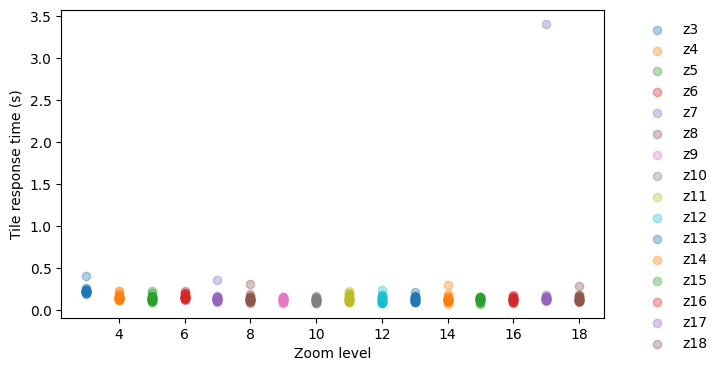

In [13]:
# Simple latency plot
if not df_tiles.empty:
    plt.figure(figsize=(7,4))
    ax = plt.gca()
    for z, sub in df_tiles.groupby("zoom"):
        ax.scatter([z]*len(sub), sub["response_time_sec"], alpha=0.35, label=f"z{z}")
    ax.set_xlabel("Zoom level")
    ax.set_ylabel("Tile response time (s)")
    handles, labels = ax.get_legend_handles_labels()
    bylabel = dict(zip(labels, handles))
    ax.legend(
        bylabel.values(),
        bylabel.keys(),
        frameon=False,
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )
    plt.show()


## Result Summaries & Plots

Interpretation tips:
- Prefer **single-day** (or narrow) intervals for responsive rendering
- Avoid very low zooms for heavy composites; consider **minzoom ≥ 7**